## Import library & Setup

In [83]:
# ✅ Standard Libraries
import os
import time
from uuid import uuid4
from typing import Literal, Optional,List
from typing_extensions import TypedDict

# ✅ Third-Party Utilities
import numpy as np
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv

# ✅ LangChain Core
from langchain_core.tools import tool
from langchain_core.messages import convert_to_messages
from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig,RunnableLambda

# ✅ LangChain Models
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_vertexai import ChatVertexAI

# ✅ LangChain MongoDB Integration
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_mongodb.retrievers.hybrid_search import MongoDBAtlasHybridSearchRetriever

# ✅ LangChain Tools / Plugins
from langchain_tavily import TavilySearch
from langchain.output_parsers.openai_functions import (
    JsonOutputFunctionsParser,
    PydanticOutputFunctionsParser
)
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain import LLMMathChain


# ✅ LangGraph
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langchain_community.callbacks import get_openai_callback

# ✅ Pydantic for Schema
from pydantic import BaseModel, Field

In [84]:
# ✅ Load variables from .env file
load_dotenv()

# ✅ Access API keys and URIs
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# ✅ Raise error if any key is missing
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY is not set in .env file")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY is not set in .env file")

# ✅ Optional: Set as environment variables for downstream tools
os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key


In [85]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## Read test data

In [86]:
data = pd.read_csv("../test.csv")

display(data.shape)
display(data.head(5))

(499, 2)

,id,query
0,36deab86-cfd3-48b5-9bea-a36c1b0e63a8,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ..."
1,2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7,Answer the question with the appropriate optio...
2,8a722080-bc16-49db-89c9-100cd61cd28a,Answer the question with the appropriate optio...
3,75316e95-88f4-4fef-83b9-dde0aa52889a,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ..."
4,bcca13bc-2675-4645-82cc-7e4c412ed294,"Given the data and tweets, could you project w..."


In [87]:
print(data.iloc[0,1])


ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น อย่าใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม

คำถาม: ______ สถานที่ทำงานเกี่ยวข้องกับการเสริมสร้างศักยภาพให้พนักงาน ตัวอย่างเช่น 'job enrichment' ที่พนักงานได้รับขอบเขตที่ใหญ่ขึ้นในการตัดสินใจว่าจะจัดระเบียบงานของตนอย่างไร หรือ 'job enlargement' ที่พนักงานได้รับมอบหมายงานที่หลากหลายมากขึ้น

ตัวเลือกคำตอบ: A: Re-invigorating, B: Re-flourishing, C: Revitalizing, D: Rehumanizing

คำตอบ:


In [88]:
# for i in range(5):
#     print(data.iloc[i,1])
#     print('\n')

## Create Agent

### Only LLM

##### Template

In [ ]:
from langchain_core.tools import Tool
from langchain import LLMMathChain

class OutputFormat(BaseModel):
    answer: str = Field(..., description="Choose the best answer from the multiple choices")
    reason: str = Field(..., description="A paragraph summarizing that leading to your conclusion")

# 2) Define input TypedDict
class InputFormat(TypedDict):
    id: str
    query: str


# 3) RCRC‐style prompt
prompt = """
<role>
You will be given a instruction and a question.
The instruction will guide you on how to respond to the question.
The question will be a financial question that requires reasoning and analysis.

Follow these steps to answer the question:
"Step1: Evaluate the context — if it's a general question or needs expert-level knowledge.\n"
"Step2: If the question is to predict rise or fall, act as a financial expert and reason step by step.\n"
"Step3: If the question asks to select among A, B, C, D, or E, and it needs general knowledge, pick the best fit. "
"If it needs advanced finance knowledge, act as a CPF-certified expert.\n"
"Step4: Respond with only the final answer — exactly one of the following: A, B, C, D, E, Rise, or Fall.\n"
"Step5: Provide a concise reason for your answer, explaining your reasoning in 32–256 tokens.\n"
</role>

<context>
ID: {id}
{query}

Use the tools in this order:
1. 🔧 Math tool -> If the question have any math calculation
</context>

<result>
Return JSON with:
- answer: best answer from the given instruction
- reason: A concise explanation justifying the answer (32–256 tokens)
</result>

<constraint>
- reason length: >32 and <256 tokens
</constraint>
"""

# 4) Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1", temperature=0.1)

# 5) Convert Pydantic schema to OpenAI function spec
function_spec = convert_pydantic_to_openai_function(OutputFormat)

# 6) Build the classification chain
chain = (
    PromptTemplate.from_template(prompt)
    | llm.bind(
        functions=[function_spec],
        function_call={"name": function_spec["name"]}
    )
    | PydanticOutputFunctionsParser(pydantic_schema=OutputFormat)
)

llm_math_chain = LLMMathChain.from_llm(llm=llm,verbose=True)
math_tool = Tool.from_function(
    func=llm_math_chain.invoke,
    name="Calculator",
    description="This tool is only for math questions, A tool for performing mathematical calculations using an LLM. It can solve equations")


# 6) Build the classification chain
general_agent = create_react_agent(
    model=llm,
    prompt=prompt,
    tools=[math_tool],
    name="general_agent",
    response_format=OutputFormat)


##### Test

In [125]:
response = general_agent.invoke(
    {
        "messages": [
            (
                "human",
                "ID: 123"
                f"""Query: {data.iloc[2,1]}"""
                
            )
        ]
    }
)

response

{'messages': [HumanMessage(content='ID: 123Query: Answer the question with the appropriate options A, B, C and D. Please respond with the exact answer A, B, C or D only. Do not be verbose or provide extra information. \nQuestion: According to COSO, which of the following is the most effective method to transmit a message of ethical behavior throughout an organization?\nAnswer Choices: A: Demonstrating appropriate behavior by example., B: Strengthening internal audit’s ability to deter and report improper behavior., C: Removing pressures to meet unrealistic targets, particularly for short-term results., D: Specifying the competence levels for every job in an organization and translating those levels to requisite knowledge and skills. \nAnswer:', additional_kwargs={}, response_metadata={}, id='f19430fd-fcb4-45ee-b036-877c7922c475'),
  AIMessage(content='{\n  "answer": "A",\n  "reason": "According to COSO, the most effective way to communicate ethical behavior is through leadership settin

In [69]:
test = data.loc[0, "query"]
print(test)

response = chain.invoke({   
    "id": 1234,
    "query": test
})

response

ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น อย่าใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม

คำถาม: ______ สถานที่ทำงานเกี่ยวข้องกับการเสริมสร้างศักยภาพให้พนักงาน ตัวอย่างเช่น 'job enrichment' ที่พนักงานได้รับขอบเขตที่ใหญ่ขึ้นในการตัดสินใจว่าจะจัดระเบียบงานของตนอย่างไร หรือ 'job enlargement' ที่พนักงานได้รับมอบหมายงานที่หลากหลายมากขึ้น

ตัวเลือกคำตอบ: A: Re-invigorating, B: Re-flourishing, C: Revitalizing, D: Rehumanizing

คำตอบ:


OutputFormat(answer='C', reason="คำถามกล่าวถึงการเสริมสร้างศักยภาพให้พนักงานในสถานที่ทำงาน เช่น 'job enrichment' และ 'job enlargement' ซึ่งเป็นแนวคิดที่เกี่ยวข้องกับการฟื้นฟูหรือกระตุ้นศักยภาพและแรงจูงใจของพนักงาน คำว่า 'Revitalizing' (ตัวเลือก C) หมายถึงการฟื้นฟูหรือทำให้มีชีวิตชีวาขึ้นใหม่ ซึ่งตรงกับบริบทของการเสริมสร้างศักยภาพและแรงจูงใจในที่ทำงาน ส่วนตัวเลือกอื่น ๆ ไม่ตรงกับความหมายนี้โดยตรง ดังนั้นคำตอบที่ถูกต้องคือ C: Revitalizing")

##### Run full dataset

In [53]:
results = []

for num, row in data.iterrows():
    input_data = InputFormat(id=row["id"], query=row["query"])
    result = chain.invoke(input_data)
    results.append([result.answer,result.reason])

    # time.sleep(0.2)  # Sleep to avoid hitting rate limits
    
    if num % 5 == 0:
        print(f"Processed {num} rows so far...")

results_df = pd.DataFrame(results)
final_df = pd.concat([data, results_df], axis=1)

# display(results_df)
display(final_df)

Processed 0 rows so far...
Processed 5 rows so far...
Processed 10 rows so far...
Processed 15 rows so far...
Processed 20 rows so far...
Processed 25 rows so far...
Processed 30 rows so far...
Processed 35 rows so far...
Processed 40 rows so far...
Processed 45 rows so far...
Processed 50 rows so far...
Processed 55 rows so far...
Processed 60 rows so far...
Processed 65 rows so far...
Processed 70 rows so far...
Processed 75 rows so far...
Processed 80 rows so far...
Processed 85 rows so far...
Processed 90 rows so far...
Processed 95 rows so far...
Processed 100 rows so far...
Processed 105 rows so far...
Processed 110 rows so far...
Processed 115 rows so far...
Processed 120 rows so far...
Processed 125 rows so far...
Processed 130 rows so far...
Processed 135 rows so far...
Processed 140 rows so far...
Processed 145 rows so far...
Processed 150 rows so far...
Processed 155 rows so far...
Processed 160 rows so far...
Processed 165 rows so far...
Processed 170 rows so far...
Process

,id,query,0,1
0,36deab86-cfd3-48b5-9bea-a36c1b0e63a8,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",C,คำตอบที่ถูกต้องคือ C: Revitalizing เนื่องจากคำ...
1,2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7,Answer the question with the appropriate optio...,B,James Dyson is the entrepreneur among the opti...
2,8a722080-bc16-49db-89c9-100cd61cd28a,Answer the question with the appropriate optio...,A,"According to COSO, the most effective way to c..."
3,75316e95-88f4-4fef-83b9-dde0aa52889a,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",C,GDP ที่แท้จริงปัจจุบันสูงกว่าระดับการจ้างงานเต...
4,bcca13bc-2675-4645-82cc-7e4c412ed294,"Given the data and tweets, could you project w...",Rise,"Based on the data, the closing price of $intc ..."
...,...,...,...,...
494,c9dd262e-405c-4078-baae-262aa48ddcc8,Answer the question with the appropriate optio...,A,The general to specific (LSE/Hendry) approach ...
495,73c720b5-1101-4790-af52-3366823e1d32,"ตอบคำถามโดยใช้ตัวเลือกที่เหมาะสม A, B, C และ D...",B,ทฤษฎี Instrumental (B) หรือทฤษฎีเชิงเครื่องมือ...
496,357db18f-d872-416e-a07f-753099853d9c,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",D,คำถามถามถึงวิธีการส่งมอบผลิตภัณฑ์ให้ตรงกับความ...
497,2d8b1419-1c46-4e83-892a-081fb417de38,Scrutinize the data and tweets to envisage if ...,Rise,"Examining the price data, $BAC's closing price..."


In [54]:
final_df.to_csv("output_llm_only.csv", index=False)

### Math agent

#### Template

In [122]:
# from langchain_core.tools import Tool
# from langchain import LLMMathChain

# llm_math_chain = LLMMathChain.from_llm(llm=llm,verbose=True)
# math_tool = Tool.from_function(
#     func=llm_math_chain.invoke,
#     name="Calculator",
#     description="This tool is only for math questions, A tool for performing mathematical calculations using an LLM. It can solve equations")

# class OutputFormat(BaseModel):
#     answer: str = Field(..., description="Accurate answer to the question")
#     reason: str = Field(..., description="Brief explanation to the answer")

# # 2) Define input TypedDict
# class InputFormat(TypedDict):
#     question: str

# math_assistant_prompt = """
# <role>
# You are advanced AI mathematics assistant. Your task is to provide accurate answer to only mathematical problems.
# You will be given a instruction and a question.
# The instruction will guide you on how to respond to the question.
# The question will be a financial question that requires reasoning and analysis.
# </role>

# <context>
# ID: {id}
# {question}

# use math_tool as calculator to solve math problems and select the best answer.

# </context>

# <result>
# Return JSON with:
# - answer: best accurate answer to the given mathematical question
# - reason: A concise explanation justifying the answer (32–256 tokens)
# </result>

# <constraint>
# - Every answer must be based on the context retrieved from the math_tool
# - Use the math_tool to retrieve context from the question
# - Reason must be >32 and <256 tokens
# - If the question is not a math question, do not use the math_tool
# </constraint>
# """

# llm = ChatOpenAI(model="typhoon-v2.1-12b-instruct"
#                  ,api_key="sk-UhhyzDwMuJfFXDuYzoGOngETFNnBVQdoL4tgrluZnTYIXtUB"
#                  ,base_url="https://api.opentyphoon.ai/v1"
#                  , temperature=0.0)

# # 6) Build the classification chain
# math_agent = create_react_agent(
#     model=llm,
#     tools=[
#         math_tool
#     ],
#     prompt=math_assistant_prompt,
#     name="math_assistant",
#     response_format=OutputFormat)

In [123]:
# response = math_agent.invoke(
#     {
#         "messages": [
#             (
#                 "human",
#                 f"""ID: 1223"""
#                 f"""Query: {data.iloc[0,1]}"""

#             )
#         ]
#     }
# )

# response

### LLM + Search Engine

#### Keyword search tools

In [107]:
class OutputFormat(BaseModel):
    keyword_seach: str = Field(..., description="A compact keyword for searching in web seach tools to get more context for answering the question")

keyword_search_prompt = """
<role>
You are a search assistant. Your task is to generate precise search keywords for financial or academic multiple-choice questions.
</role>

<context>
Question and choice: {query}
</context>

<result>
Return JSON with:
- keyword_search: A concise phrase optimized for Google or Bing (no full sentences; use financial/domain terms only)
</result>

Generate a concise **search keyword phrase** that would help someone find the correct answer to this question using Google or Bing.
Use key financial or domain-specific terms (avoid full sentence).
"""

# 4) Initialize the LLM
keyword_search_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

# 5) Convert Pydantic schema to OpenAI function spec
keyword_search_function_spec = convert_pydantic_to_openai_function(OutputFormat)

# 6) Build the classification chain
keyword_search_chain = (
    PromptTemplate.from_template(keyword_search_prompt)
    | keyword_search_llm.bind(
        functions=[keyword_search_function_spec],
        function_call={"name": keyword_search_function_spec["name"]}
    )
    | PydanticOutputFunctionsParser(pydantic_schema=OutputFormat)
)

In [108]:
keyword_search_chain_tool = keyword_search_chain.as_tool(
    name="keyword_search_chain_tool",
    description="Find keywords for input into seach engine from question and answer choice",
)
keyword_search_result = keyword_search_chain_tool.invoke({"query": data.loc[0, "query"]})

keyword_search_result

OutputFormat(keyword_seach='job enrichment job enlargement workplace empowerment')

#### Tavily Search

In [ ]:
search_tool = TavilySearch(
    max_results=3,
    topic="general",
)

In [ ]:
search_result = search_tool.invoke("job enrichment job enlargement workplace empowerment")
search_result

{'query': 'job enrichment job enlargement workplace empowerment',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is Employee Empowerment? Job Involvement & Culture - ASQ',
   'url': 'https://asq.org/quality-resources/employee-empowerment',
   'content': "Employee empowerment varies based on an organization's culture and work design. However, empowerment is based on the concepts of job enlargement and job enrichment. Job enlargement differs from job enrichment in that job enlargement is horizontal expansion and job enrichment is considered vertical. Job enlargement: Horizontal job expansion by",
   'score': 0.82795376,
   'raw_content': None},
  {'title': 'Job Enrichment: A Pathway to Employee Empowerment',
   'url': 'https://www.eleapsoftware.com/glossary/job-enrichment-a-pathway-to-employee-empowerment/',
   'content': 'Job Enrichment: A Pathway to Employee Empowerment - eLeaP® Employee engagement is essential for any organization’s success;

#### Final search engine agent

##### Template

In [111]:
class OutputFormat(BaseModel):
    answer: str = Field(..., description="Choose the best answer from the multiple choices")
    reason: str = Field(..., description="A paragraph summarizing that leading to your conclusion")

# 2) Define input TypedDict
class InputFormat(TypedDict):
    id: str
    query: str

web_search_prompt = """
<role>
You are the expert in multiple-choice question answering. 
You will be given a instruction and a question.

"Step1: Evaluate the context — if it's a general question or needs expert-level knowledge.\n"
"Step2: If the question is to predict rise or fall, act as a financial expert and reason step by step.\n"
"Step3: If the question asks to select among A, B, C, D, or E, and it needs general knowledge, pick the best fit. "
"If it needs advanced finance knowledge, act as a CPF-certified expert.\n"
"Step4: Respond with only the final answer — exactly one of the following: A, B, C, D, E, Rise, or Fall.\n"
"Answer in English only. Do not explain or add anything else."

</role>

<context>
ID: {id}
{query}

Use the tools in this order:
1. 🔧 Keyword search → extract search phrase from the input question and choice  
2. 🔧 Search tool → retrieve context from the search results to get content and url

Get context from Web search to help finding the correct answer
</context>

<result>
Return JSON with:
- answer: best answer from the given instruction
- reason: A concise explanation justifying the answer (32–256 tokens)
</result>

<constraint>
- Every answer must be based on the context retrieved from the search tools
- Use the keyword search tool to extract a search phrase from the question and choice
- Use the search tool to retrieve context from the keyword search results
- Reason must be >32 and <256 tokens
</constraint>
"""

llm = ChatOpenAI(model="gpt-4.1", temperature=0.0)
# 6) Build the classification chain
web_search_agent = create_react_agent(
    model=llm,
    tools=[
        keyword_search_chain_tool,
        search_tool
    ],
    prompt=web_search_prompt,
    name="websearch_with_tools",
    response_format=OutputFormat)

In [112]:
class OutputFormat(BaseModel):
    answer: str = Field(..., description="Choose the best answer from the multiple choices")
    reason: str = Field(..., description="A paragraph summarizing that leading to your conclusion")

# 2) Define input TypedDict
class InputFormat(TypedDict):
    id: str
    query: str

web_search_prompt = """
<role>
You are the expert in multiple-choice question answering. 
You will be given a instruction and a question.
Your task is to select the best answer and provide a concise explanation for your choice.
</role>

<context>
ID: {id}
{query}

Use the tools in this order:
1. 🔧 Search tool → retrieve context from question that need web search to reference
2. 🔧 Math tool → retrieve context from question that need web search to reference

Get context from Web search to help finding the correct answer
</context>

<result>
Return JSON with:
- answer: best answer from the given instruction
- reason: A concise explanation justifying the answer (32–256 tokens)
</result>

<constraint>
- Every answer must be based on the context retrieved from the search tools
- Use the keyword search tool to extract a search phrase from the question and choice
- Use the search tool to retrieve context from the keyword search results
- Reason must be >32 and <256 tokens
</constraint>
"""

llm = ChatOpenAI(model="gpt-4.1", temperature=0.0)
# 6) Build the classification chain
web_search_agent = create_react_agent(
    model=llm,
    tools=[
        keyword_search_chain_tool,
        search_tool
    ],
    prompt=web_search_prompt,
    name="websearch_with_tools",
    response_format=OutputFormat)



##### Test

In [113]:
response = web_search_agent.invoke(
    {
        "messages": [
            (
                "human",
                "ID: 123"
                f"""Query: {data.iloc[2,1]}"""
                
            )
        ]
    }
)

response

{'messages': [HumanMessage(content='ID: 123Query: Answer the question with the appropriate options A, B, C and D. Please respond with the exact answer A, B, C or D only. Do not be verbose or provide extra information. \nQuestion: According to COSO, which of the following is the most effective method to transmit a message of ethical behavior throughout an organization?\nAnswer Choices: A: Demonstrating appropriate behavior by example., B: Strengthening internal audit’s ability to deter and report improper behavior., C: Removing pressures to meet unrealistic targets, particularly for short-term results., D: Specifying the competence levels for every job in an organization and translating those levels to requisite knowledge and skills. \nAnswer:', additional_kwargs={}, response_metadata={}, id='44858479-a964-463f-9777-f37db6be4003'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dl6kfFJduiqojstuA31C7UsU', 'function': {'arguments': '{"query":"COSO most effective me

In [46]:
display(response['structured_response'].answer)
display(response['structured_response'].reason)

'A'

"According to COSO, the most effective way to transmit a message of ethical behavior throughout an organization is by demonstrating appropriate behavior by example. This approach is emphasized in COSO's framework as it sets a clear standard for others to follow and reinforces the organization's commitment to ethical conduct."

In [ ]:
print(data.iloc[2,1])

response = chain.invoke({   
    "id": 1234,
    "query": data.iloc[2,1]
})

response

ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น อย่าใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม

คำถาม: ______ สถานที่ทำงานเกี่ยวข้องกับการเสริมสร้างศักยภาพให้พนักงาน ตัวอย่างเช่น 'job enrichment' ที่พนักงานได้รับขอบเขตที่ใหญ่ขึ้นในการตัดสินใจว่าจะจัดระเบียบงานของตนอย่างไร หรือ 'job enlargement' ที่พนักงานได้รับมอบหมายงานที่หลากหลายมากขึ้น

ตัวเลือกคำตอบ: A: Re-invigorating, B: Re-flourishing, C: Revitalizing, D: Rehumanizing

คำตอบ:


OutputFormat(answer='A', reason='Demonstrating appropriate behavior by example is the most effective method to transmit a message of ethical behavior throughout an organization, as it sets a standard for employees to follow. When leaders and management exemplify ethical conduct, it fosters a culture of integrity and encourages employees to emulate that behavior. This approach is more impactful than merely establishing policies or removing pressures, as it directly influences the organizational climate and employee attitudes towards ethics.')

##### Run full dataset

In [49]:
results = []

for num, row in data.iterrows():
    response = web_search_agent.invoke(
        {
            "messages": [
                (
                    "human",
                    f"""ID: {row["id"]}"""
                    f"""Query: {row["query"]}"""
                    
                )
            ]
        }
    )
    results.append([response['structured_response'].answer, response['structured_response'].reason])

    time.sleep(0.1)  # Sleep to avoid hitting rate limits
    
    if num % 5 == 0:
        print(f"Processed {num} rows so far...")

results_df = pd.DataFrame(results)
final_df = pd.concat([data, results_df], axis=1)

# display(results_df)
display(final_df)

Processed 0 rows so far...
Processed 5 rows so far...
Processed 10 rows so far...
Processed 15 rows so far...
Processed 20 rows so far...
Processed 25 rows so far...
Processed 30 rows so far...
Processed 35 rows so far...
Processed 40 rows so far...
Processed 45 rows so far...
Processed 50 rows so far...
Processed 55 rows so far...
Processed 60 rows so far...
Processed 65 rows so far...
Processed 70 rows so far...
Processed 75 rows so far...
Processed 80 rows so far...
Processed 85 rows so far...
Processed 90 rows so far...
Processed 95 rows so far...
Processed 100 rows so far...
Processed 105 rows so far...
Processed 110 rows so far...
Processed 115 rows so far...
Processed 120 rows so far...
Processed 125 rows so far...
Processed 130 rows so far...
Processed 135 rows so far...
Processed 140 rows so far...
Processed 145 rows so far...
Processed 150 rows so far...
Processed 155 rows so far...
Processed 160 rows so far...
Processed 165 rows so far...
Processed 170 rows so far...
Process

,id,query,0,1
0,36deab86-cfd3-48b5-9bea-a36c1b0e63a8,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",D,คำว่า 'Rehumanizing' หมายถึงการทำให้สถานที่ทำง...
1,2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7,Answer the question with the appropriate optio...,B,James Dyson is widely recognized as an entrepr...
2,8a722080-bc16-49db-89c9-100cd61cd28a,Answer the question with the appropriate optio...,A,"According to COSO, the most effective way to t..."
3,75316e95-88f4-4fef-83b9-dde0aa52889a,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",C,เมื่อ GDP ที่แท้จริงสูงกว่าระดับการจ้างงานเต็ม...
4,bcca13bc-2675-4645-82cc-7e4c412ed294,"Given the data and tweets, could you project w...",Rise,"Looking at the data, the closing price on 2018..."
...,...,...,...,...
494,c9dd262e-405c-4078-baae-262aa48ddcc8,Answer the question with the appropriate optio...,A,A key disadvantage of the general to specific ...
495,73c720b5-1101-4790-af52-3366823e1d32,"ตอบคำถามโดยใช้ตัวเลือกที่เหมาะสม A, B, C และ D...",B,ทฤษฎี Instrumental (เชิงเครื่องมือ) อธิบายว่าผ...
496,357db18f-d872-416e-a07f-753099853d9c,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",D,การส่งมอบผลิตภัณฑ์ให้ตรงกับความต้องการของลูกค้...
497,2d8b1419-1c46-4e83-892a-081fb417de38,Scrutinize the data and tweets to envisage if ...,Rise,The closing price of $BAC on 2017-12-12 was up...


In [50]:
final_df.to_csv("output_llm_search_engine.csv", index=False)

### RAG

## Supervisor

#### Template

In [132]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from typing import Optional, Literal
from pydantic import BaseModel, Field

class SupervisorOutput(BaseModel):
    id: str = Field(..., description="The name of the product to classify.")
    query: str = Field(..., description="The name of the product to classify.")
    answer: str = Field(..., description="Choose the best answer from the multiple choices")
    reason: str = Field(..., description="A paragraph summarizing that leading to your conclusion")
    confidence_score: Optional[float]
    route_to: Optional[str]

supervisor_prompt = """
You are a supervisor agent responsible for overseeing the multiple choice question answering.

<Role>
- Receive outputs from specialized agents (general_agent, web_search_agent).
- Interpret the overall result and produce a final structured summary.
- Decide whether confidence score is high or needs rerouting.
- Ensure fallback routing (e.g., to general_agent or web_search_agent) follows a strict logic path.

Question: {query}
Current iteration: {iteration}
Previous result: {previous_result}

Instructions:
1. If the question is general knowledge send to the general_agent
2. If the question requires external information or up-to-date facts, use web_search_agent or rag_agent.
   - Use web_search_agent if the information is likely available via search engines.
   - Use rag_agent if internal knowledge base (e.g., documents) might help.

After receiving the answer:
- Assess the answer and give a confidence score between 0 and 1.
- If confidence < 0.7, write constructive feedback to improve the response.
- If confidence ≥ 0.7, accept the answer.

Rules:
- Retry up to 3 times if confidence is low.
- Always select ONE agent to send to on each retry.
<result>
Return JSON with:
- answer: best answer from the given instruction
- reason: A concise explanation justifying the answer (32–256 tokens)
</result>

<constraint>
- Reason must be >32 and <256 tokens
- Answer should be only A,B,C,D,E,Rise,Fall
- If there are Rise and Fall in Thai language, then answer should be in English only
</constraint>
"""

# === CREATE AND COMPILE SUPERVISOR ===
supervisor = create_supervisor(
    model=llm,
    # state_schema=StateSchema,
    agents=[general_agent, web_search_agent],
    prompt=supervisor_prompt,
    response_format=SupervisorOutput,
    add_handoff_back_messages=True,
    supervisor_name="supervisor",
).compile()

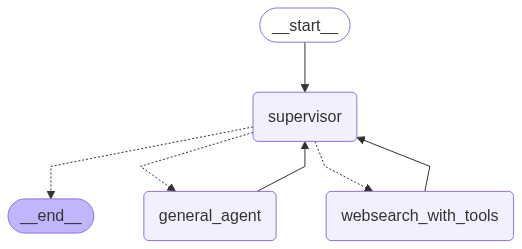

In [133]:
supervisor

In [134]:
test = """ตอบคำถามโดยใช้ตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น ห้ามใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม
คำถาม: Felton Farm Supplies, Inc. มีผลตอบแทนจากสินทรัพย์รวม 8 เปอร์เซ็นต์ของ $300,000 และอัตรากำไรสุทธิ 5 เปอร์เซ็นต์ ยอดขายของบริษัทคือเท่าใด
ตัวเลือกคำตอบ: A: $3,750,000.00, B: $480,000, C: $300,000, D: $1,500,000
คำตอบ:"""

In [135]:
response = supervisor.invoke(
    {
        "messages": [
            (
                "human",
                "ID: 123"
                f"""Query: {test}"""
                
            )
        ]
    }
)

response

{'messages': [HumanMessage(content='ID: 123Query: ตอบคำถามโดยใช้ตัวเลือกที่เหมาะสม A, B, C และ D โปรดตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น ห้ามใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม\nคำถาม: Felton Farm Supplies, Inc. มีผลตอบแทนจากสินทรัพย์รวม 8 เปอร์เซ็นต์ของ $300,000 และอัตรากำไรสุทธิ 5 เปอร์เซ็นต์ ยอดขายของบริษัทคือเท่าใด\nตัวเลือกคำตอบ: A: $3,750,000.00, B: $480,000, C: $300,000, D: $1,500,000\nคำตอบ:', additional_kwargs={}, response_metadata={}, id='f1729b69-28a6-4db2-930f-0e53081b9d19'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e3ToVV1P1wADM2PzSLBMmb3t', 'function': {'arguments': '{}', 'name': 'transfer_to_general_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 554, 'total_tokens': 566, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 

In [137]:
results = []

for num, row in data.iterrows():
    result = supervisor.invoke(
    {
        "messages": [
            (
                "human",
                f"""ID: {row["id"]}"""
                f"""Query: {row["query"]}"""
                
            )
        ]
    }
)
    results.append([result['structured_response'].answer,result['structured_response'].reason])

    time.sleep(0.2)  # Sleep to avoid hitting rate limits
    
    if num % 5 == 0:
        print(f"Processed {num} rows so far...")
    break
results_df = pd.DataFrame(results)
final_df = pd.concat([data, results_df], axis=1)

# display(results_df)
display(final_df)

Processed 0 rows so far...


,id,query,0,1
0,36deab86-cfd3-48b5-9bea-a36c1b0e63a8,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",C,คำว่า 'Revitalizing' หมายถึงการทำให้มีชีวิตชีว...
1,2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7,Answer the question with the appropriate optio...,NaN,NaN
2,8a722080-bc16-49db-89c9-100cd61cd28a,Answer the question with the appropriate optio...,NaN,NaN
3,75316e95-88f4-4fef-83b9-dde0aa52889a,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",NaN,NaN
4,bcca13bc-2675-4645-82cc-7e4c412ed294,"Given the data and tweets, could you project w...",NaN,NaN
...,...,...,...,...
494,c9dd262e-405c-4078-baae-262aa48ddcc8,Answer the question with the appropriate optio...,NaN,NaN
495,73c720b5-1101-4790-af52-3366823e1d32,"ตอบคำถามโดยใช้ตัวเลือกที่เหมาะสม A, B, C และ D...",NaN,NaN
496,357db18f-d872-416e-a07f-753099853d9c,"ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D โ...",NaN,NaN
497,2d8b1419-1c46-4e83-892a-081fb417de38,Scrutinize the data and tweets to envisage if ...,NaN,NaN


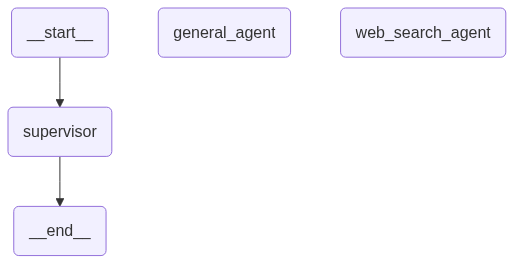

In [36]:
app

In [37]:
# === Run ===
initial_state: State = {
    "query": "Who won the World Cup in 2022?",
    "previous_result": "",
    "feedback": "",
    "confidence": 0.0,
    "route_to": "",
    "iteration": 0,
    "final_answer": ""
}

final_state = app.invoke(initial_state)
print("Final Answer:", final_state["final_answer"])
print("Confidence:", final_state["confidence"])
print("Iteration:", final_state["iteration"])
print("Route Taken:", final_state["route_to"])
print("Feedback:", final_state["feedback"])

Final Answer: 
Confidence: 0.8
Iteration: 1
Route Taken: web_search_agent
Feedback: 


#### Test

In [24]:
print(data.iloc[2,1])

Answer the question with the appropriate options A, B, C and D. Please respond with the exact answer A, B, C or D only. Do not be verbose or provide extra information. 
Question: According to COSO, which of the following is the most effective method to transmit a message of ethical behavior throughout an organization?
Answer Choices: A: Demonstrating appropriate behavior by example., B: Strengthening internal audit’s ability to deter and report improper behavior., C: Removing pressures to meet unrealistic targets, particularly for short-term results., D: Specifying the competence levels for every job in an organization and translating those levels to requisite knowledge and skills. 
Answer:


In [38]:
response = app.invoke(
    {
        "messages": [
            (
                "human",
                "ID: 123"
                f"""Query: {data.iloc[2,1]}"""
                
            )
        ]
    }
)

response

KeyError: 'query'